In [1]:
from SELMA_utils import *
from matplotlib import pyplot as plt
import seaborn as sns
import tikzplotlib

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# The ground truth

BBOX
BBOX
BBOX


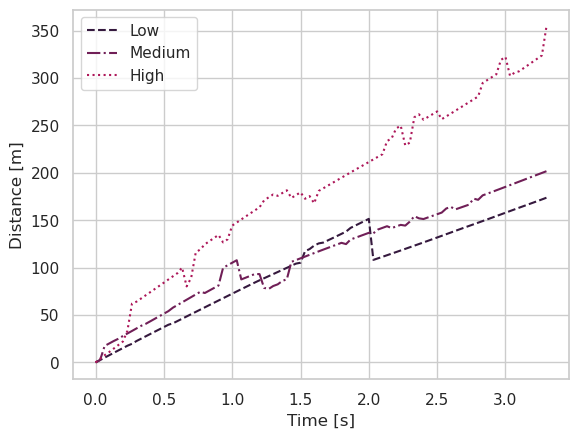

In [3]:
def find_ground_truth(root:str, town:Town, traffic:Traffic, id:int, weather:Weather, time:Time, sensor:Sensor, t:int, n:int):
    cs = [0]
    file_path    = get_filepath(root, town, traffic, id, weather, time, sensor)
    bb_file_path = get_filepath(root, town, traffic, id, weather, time, Sensor.BB)
    bbs          = open_bounding_boxes(bb_file_path)
    pointcloud, ground_truth = open_measurement_sample_TLC(file_path, t)
    in_vision_ids = np.unique(ground_truth[:,0])
    in_vision_dataset = bbs[(bbs["time step"]==t) & (bbs["ID"].isin(in_vision_ids))]
    starting_in_vision_dict = {}
    # for each row in in_vision_dataset add the position to the dictionary
    for index, row in in_vision_dataset.iterrows():
        a = row[["location x","location y","location z"]].values
        a = np.array(a, dtype=np.float32)
        starting_in_vision_dict[row["ID"]] = a

    for timestep in range(t+1, t+n):
        c = 0

        ego_position = bbs[(bbs["time step"]==timestep) & (bbs["ID"]==id)][["location x","location y","location z"]].values[0]
        ego_position = np.array(ego_position, dtype=np.float32)
        pointcloud, ground_truth = open_measurement_sample_TLC(file_path, timestep)
        in_vision_ids = np.unique(ground_truth[:,0])
        in_vision_dataset = bbs[(bbs["time step"]==timestep) & (bbs["ID"].isin(in_vision_ids))]
        for index, row in in_vision_dataset.iterrows():
            a = row[["location x","location y","location z"]].values
            a = np.array(a, dtype=np.float32)
            if row["ID"] in starting_in_vision_dict:
                c += np.linalg.norm(a - starting_in_vision_dict[row["ID"]])
            else:
                c += 1000/np.linalg.norm(a - ego_position)
        cs.append(c)
    return cs
starting_index = 0
length = 100
b = find_ground_truth("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Low, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length)
c = find_ground_truth("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Medium, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length)
d = find_ground_truth("/home/filo/SELMA_utils/archives", Town.T1, Traffic.High, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length)
x = np.arange(0, 1/30*length, 1/30)
# plot a,b,c,d in the same plot using seaborn
# use different colors and markers
# add a legend

sns.set_theme(palette="rocket",style="whitegrid")
plt.plot(x, b, label="Low", linestyle='--')
plt.plot(x, c, label="Medium", linestyle='-.')
plt.plot(x, d, label="High", linestyle=':')
plt.xlabel("Time [s]")
plt.ylabel("Distance [m]")
plt.legend()
tikzplotlib.save("correlation.tex")
plt.show()

BBOX
BBOX
BBOX


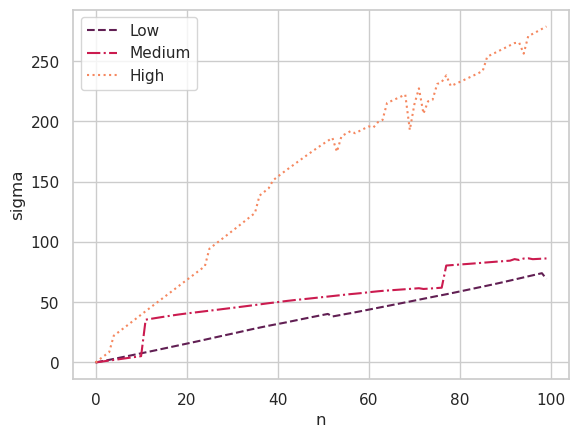

In [4]:
starting_index = 1000
length = 100
b = find_ground_truth("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Low, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length)
c = find_ground_truth("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Medium, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length)
d = find_ground_truth("/home/filo/SELMA_utils/archives", Town.T1, Traffic.High, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length)
x = np.arange(0, length)
# plot a,b,c,d in the same plot using seaborn
# use different colors and markers
# add a legend
palette = sns.color_palette("rocket", n_colors=3)
sns.set_theme(style="whitegrid")
plt.tick_params(axis='both', which='both', top=False, right=False)
plt.plot(x, b, label="Low", linestyle='--', color=palette[0])
plt.plot(x, c, label="Medium", linestyle='-.', color=palette[1])
plt.plot(x, d, label="High", linestyle=':', color=palette[2])
plt.xlabel("n")
plt.ylabel("sigma")
plt.legend()
tikzplotlib.save("correlation.tex")
plt.show()

In [ ]:
starting_index = 1000
length = 100
b = find_ground_truth("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Low, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length)
c = find_ground_truth("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Medium, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length)
d = find_ground_truth("/home/filo/SELMA_utils/archives", Town.T1, Traffic.High, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length)
x = np.arange(0, length)
# plot a,b,c,d in the same plot using seaborn
# use different colors and markers
# add a legend
palette = sns.color_palette("rocket", n_colors=3)
b = np.array(b)
c = np.array(c)
d = np.array(d)
sns.set_theme(style="whitegrid")
plt.tick_params(axis='both', which='both', top=False, right=False)
plt.plot(x, 1/b, label="Low", linestyle='--', color=palette[0])
plt.plot(x, 1/c, label="Medium", linestyle='-.', color=palette[1])
plt.plot(x, 1/d, label="High", linestyle=':', color=palette[2])
plt.xlabel("n")
plt.ylabel("sigma")
plt.legend()
tikzplotlib.save("true_correlation.tex")
plt.show()

# Voxels

In [2]:
import numpy as np

def align_on_map(pc, bboxes, sensor_data, id):
    pc = np.hstack([pc, np.ones((pc.shape[0], 1))])
    vehicle_world_matrix = get_matrix([bboxes[bboxes["ID"] == id]["location x"].iloc[0], 
                                    -bboxes[bboxes["ID"] == id]["location y"].iloc[0],
                                    bboxes[bboxes["ID"] == id]["location z"].iloc[0]], 
                                    [sensor_data["relative_rot"].get("roll",0)+bboxes[bboxes["ID"] == id]["rotation x"].iloc[0],
                                    sensor_data["relative_rot"].get("pitch",0)+bboxes[bboxes["ID"] == id]["rotation y"].iloc[0],
                                    -sensor_data["relative_rot"].get("yaw",0)-bboxes[bboxes["ID"] == id]["rotation z"].iloc[0]])
    pc = np.dot(vehicle_world_matrix, pc.T).T

    # compensate for the sensor
    sensor_vector = [sensor_data["relative_loc"].get("dx",0),
                    -sensor_data["relative_loc"].get("dy",0),
                    sensor_data["relative_loc"].get("dz",0)]
    sensor_vector = np.array(sensor_vector)
    vehicle_rotation = get_matrix([0,0,0], 
                                [+bboxes[bboxes["ID"] == id]["rotation x"].iloc[0],
                                +bboxes[bboxes["ID"] == id]["rotation y"].iloc[0],
                                -bboxes[bboxes["ID"] == id]["rotation z"].iloc[0]])
    sensor_vector = np.dot(vehicle_rotation[:3,:3], sensor_vector.T)
    pc = np.array(pc[:,:3])+ np.array(sensor_vector)[0]
    return pc





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
BBOX
BBOX
BBOX
BBOX
BBOX
BBOX


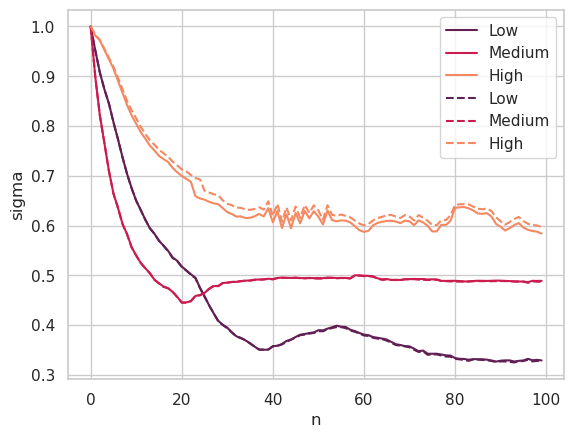

In [25]:
%load_ext autoreload
%autoreload 2

from SELMA_utils import *
from selmaPointCloud import *
from voxels import *
import json
import open3d as o3d
from matplotlib import pyplot as plt
import tikzplotlib
import seaborn as sns


def find_voxel_correlation(root:str, town:Town, traffic:Traffic, id:int, weather:Weather, time:Time, sensor:Sensor, t:int, n:int, voxel_size:float, crop_street:bool, weigthed=False):
    cs = [1]
    file_path    = get_filepath(root, town, traffic, id, weather, time, sensor)
    bb_file_path = get_filepath(root, town, traffic, id, weather, time, Sensor.BB)
    bbs          = open_bounding_boxes(bb_file_path)
    pointcloud, ground_truth = open_measurement_sample_TLC(file_path, t)

    sensor_path = "/home/filo/SELMA_utils/sensors_vehicles/sensor_vehicle.seat.leon.json"
    with open(sensor_path) as json_file:
        sensors_data = json.load(json_file)
    sensor_data = sensors_data[sensor.value]

    bboxes = bbs[bbs["time step"] == t]

    pointcloud = align_on_map(pointcloud, bboxes, sensor_data, id)
    
    spc_t = SelmaPointCloud(pointcloud, ground_truth)

    for timestep in range(t+1, t+n):
        bboxes = bbs[bbs["time step"] == timestep]
        pointcloud, ground_truth = open_measurement_sample_TLC(file_path, timestep)
        pointcloud = align_on_map(pointcloud, bboxes, sensor_data, id)
        spc_ti = SelmaPointCloud(pointcloud, ground_truth)
        correlation = spc_t.compare_using_voxels(spc_ti, voxel_size, weighted=weigthed, mode=selmaPointCloud.NO, crop_street=crop_street)
        cs.append(correlation)
    return cs
starting_index = 1000
length = 100

b = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Low, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 0.5, False)
c = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Medium, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 0.5, False)
d = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.High, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 0.5, False)
x = np.arange(0, length)


# plot a,b,c,d in the same plot using seaborn
# use different colors and markers
# add a legend
palette = sns.color_palette("rocket", n_colors=3)
sns.set_theme(style="whitegrid")
plt.tick_params(axis='both', which='both', top=False, right=False)
plt.plot(x, b, label="Low",  color=palette[0])
plt.plot(x, c, label="Medium",  color=palette[1])
plt.plot(x, d, label="High",  color=palette[2])

b = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Low, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 0.5, False, weigthed=True)
c = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Medium, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 0.5, False, weigthed=True)
d = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.High, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 0.5, False, weigthed=True)
plt.plot(x, b, label="Low", linestyle="--", color=palette[0])
plt.plot(x, c, label="Medium", linestyle="--", color=palette[1])
plt.plot(x, d, label="High", linestyle="--", color=palette[2])
plt.xlabel("n")
plt.ylabel("sigma")
plt.legend()
tikzplotlib.save("voxel_with_street.tex")
plt.show()

BBOX
BBOX
BBOX
BBOX
BBOX
BBOX


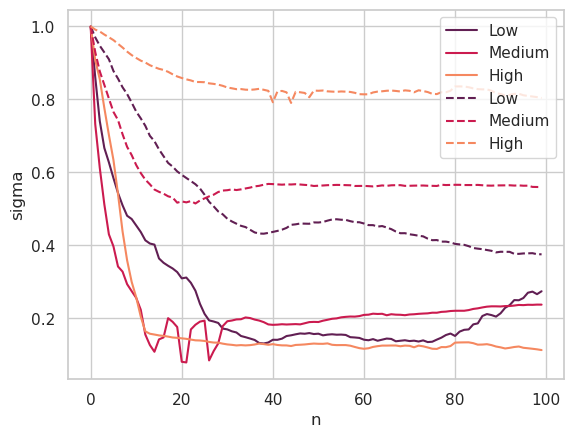

In [26]:
starting_index = 1000
length = 100
b = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Low, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 0.1, True)
c = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Medium, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 0.1, True)
d = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.High, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 0.1, True)
x = np.arange(0, length)
# plot a,b,c,d in the same plot using seaborn
# use different colors and markers
# add a legend
palette = sns.color_palette("rocket", n_colors=3)
sns.set_theme(style="whitegrid")
plt.tick_params(axis='both', which='both', top=False, right=False)
plt.plot(x, b, label="Low", color=palette[0])
plt.plot(x, c, label="Medium", color=palette[1])
plt.plot(x, d, label="High", color=palette[2])
plt.xlabel("n")
plt.ylabel("sigma")
b = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Low, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 1, True)
c = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Medium, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 1, True)
d = find_voxel_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.High, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length, 1, True)
plt.plot(x, b, label="Low", linestyle="--", color=palette[0])
plt.plot(x, c, label="Medium", linestyle="--", color=palette[1])
plt.plot(x, d, label="High", linestyle="--", color=palette[2])
plt.legend()
tikzplotlib.save("voxel_without_street.tex")
plt.show()

# Clusters

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
from SELMA_utils import *
from selmaPointCloud import *
from voxels import *
import json
import open3d as o3d
from matplotlib import pyplot as plt
import tikzplotlib
import seaborn as sns

def align_on_map(pc, bboxes, sensor_data, id):
    pc = np.hstack([pc, np.ones((pc.shape[0], 1))])
    vehicle_world_matrix = get_matrix([bboxes[bboxes["ID"] == id]["location x"].iloc[0], 
                                    -bboxes[bboxes["ID"] == id]["location y"].iloc[0],
                                    bboxes[bboxes["ID"] == id]["location z"].iloc[0]], 
                                    [sensor_data["relative_rot"].get("roll",0)+bboxes[bboxes["ID"] == id]["rotation x"].iloc[0],
                                    sensor_data["relative_rot"].get("pitch",0)+bboxes[bboxes["ID"] == id]["rotation y"].iloc[0],
                                    -sensor_data["relative_rot"].get("yaw",0)-bboxes[bboxes["ID"] == id]["rotation z"].iloc[0]])
    pc = np.dot(vehicle_world_matrix, pc.T).T

    # compensate for the sensor
    sensor_vector = [sensor_data["relative_loc"].get("dx",0),
                    -sensor_data["relative_loc"].get("dy",0),
                    sensor_data["relative_loc"].get("dz",0)]
    sensor_vector = np.array(sensor_vector)
    vehicle_rotation = get_matrix([0,0,0], 
                                [+bboxes[bboxes["ID"] == id]["rotation x"].iloc[0],
                                +bboxes[bboxes["ID"] == id]["rotation y"].iloc[0],
                                -bboxes[bboxes["ID"] == id]["rotation z"].iloc[0]])
    sensor_vector = np.dot(vehicle_rotation[:3,:3], sensor_vector.T)
    pc = np.array(pc[:,:3])+ np.array(sensor_vector)[0]
    return pc

def find_kmeans_correlation(root:str, town:Town, traffic:Traffic, id:int, weather:Weather, time:Time, sensor:Sensor, t:int, n:int, n_clusters:float, crop_street:bool):
    cs = [1]
    file_path    = get_filepath(root, town, traffic, id, weather, time, sensor)
    bb_file_path = get_filepath(root, town, traffic, id, weather, time, Sensor.BB)
    bbs          = open_bounding_boxes(bb_file_path)
    pointcloud, ground_truth = open_measurement_sample_TLC(file_path, t)

    sensor_path = "/home/filo/SELMA_utils/sensors_vehicles/sensor_vehicle.seat.leon.json"
    with open(sensor_path) as json_file:
        sensors_data = json.load(json_file)
    sensor_data = sensors_data[sensor.value]

    bboxes = bbs[bbs["time step"] == t]

    pointcloud = align_on_map(pointcloud, bboxes, sensor_data, id)
    
    spc_t = SelmaPointCloud(pointcloud, ground_truth)

    for timestep in range(t+1, t+n):
        bboxes = bbs[bbs["time step"] == timestep]
        pointcloud, ground_truth = open_measurement_sample_TLC(file_path, timestep)
        pointcloud = align_on_map(pointcloud, bboxes, sensor_data, id)
        spc_ti = SelmaPointCloud(pointcloud, ground_truth)
        correlation = spc_t.compare_using_clusters(spc_ti, n_clusters, mode=selmaPointCloud.NO, crop_street=crop_street, return_mse=True)
        cs.append(correlation)
    return cs


BBOX
BBOX
BBOX


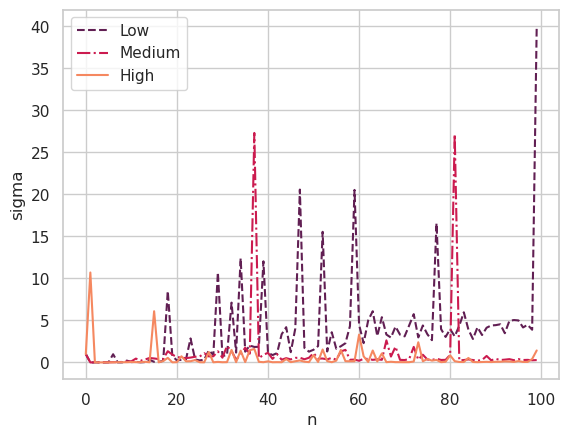

In [17]:
starting_index = 1000
length = 100
b = find_kmeans_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Low, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length,10,True)
c = find_kmeans_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Medium, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length,10,True)
d = find_kmeans_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.High, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length,10,True)
x = np.arange(0, length)
# plot a,b,c,d in the same plot using seaborn
# use different colors and markers
# add a legend
palette = sns.color_palette("rocket", n_colors=3)
sns.set_theme(style="whitegrid")
plt.tick_params(axis='both', which='both', top=False, right=False)
plt.plot(x, b, label="Low", linestyle='--', color=palette[0])
plt.plot(x, c, label="Medium", linestyle='-.', color=palette[1])
plt.plot(x, d, label="High", color=palette[2])
plt.xlabel("n")
plt.ylabel("sigma")
plt.legend()
tikzplotlib.save("kmeans_10.tex")
plt.show()

BBOX
BBOX
BBOX


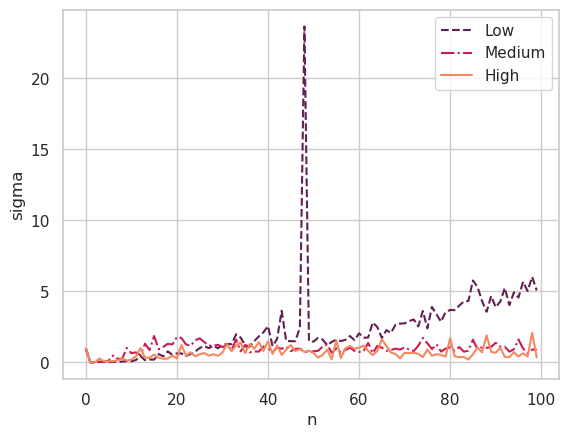

In [18]:
starting_index = 1000
length = 100
b = find_kmeans_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Low, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length,100,True)
c = find_kmeans_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.Medium, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length,100,True)
d = find_kmeans_correlation("/home/filo/SELMA_utils/archives", Town.T1, Traffic.High, 0, Weather.Clear, Time.Sunset, Sensor.LT,starting_index, length,100,True)
x = np.arange(0, length)
# plot a,b,c,d in the same plot using seaborn
# use different colors and markers
# add a legend
palette = sns.color_palette("rocket", n_colors=3)
sns.set_theme(style="whitegrid")
plt.tick_params(axis='both', which='both', top=False, right=False)
plt.plot(x, b, label="Low", linestyle='--', color=palette[0])
plt.plot(x, c, label="Medium", linestyle='-.', color=palette[1])
plt.plot(x, d, label="High", color=palette[2])
plt.xlabel("n")
plt.ylabel("sigma")
plt.legend()
tikzplotlib.save("kmeans_100.tex")
plt.show()